In [102]:
#!pip install statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [103]:
np.random.seed(0)

n = 200
theta1 = 0.8
theta2 = 0.3
mu = 5
eps = np.random.normal(0, 1, n)

x = np.zeros(n)
for t in range(2, n):
    x[t] = mu + eps[t] + theta1 * eps[t-1] + theta2 * eps[t-2]

df = pd.DataFrame(pd.Series(x), columns=['values'])
print(df.head())

     values
0  0.000000
1  0.000000
2  6.828079
3  8.143931
4  8.953894


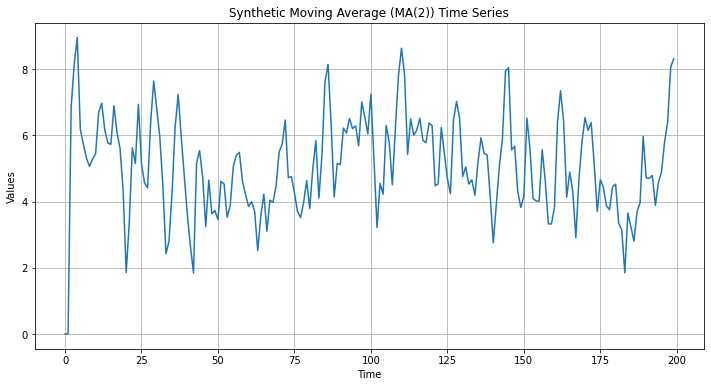

In [104]:
plt.figure(figsize=(12,6))
plt.plot(df)
plt.title('Synthetic Moving Average (MA(2)) Time Series')
plt.xlabel('Time')
plt.ylabel('Values')
plt.grid()
plt.show()

Parece naturalmente estacionaria, pero igualmente lo chequeamos

In [105]:
ADF_result = adfuller(df['values'])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -8.6783560766619
p-value: 4.353774019216752e-14


El p-valor es muy bajo, por tanto no rechazamos la hipótesis nula de que la serie tiene una raíz unitaria. La serie es estacionaria, no requiere ser diferenciada.

Ahora chequeamos autocorrelación, vemos que los coeficientes son significativos hasta el orden 2, por tanto tenemos un moving average process de orden 2, podemos usar entonces un modelo de MA de orden dos para realizar pronosticos sobre nuestra serie.

In [106]:
alpha = 0.05
acv = acf(df["values"], nlags=5, alpha=alpha)
acv[0]

array([ 1.        ,  0.61230457,  0.18584285, -0.02695921, -0.05570073,
        0.03553797])

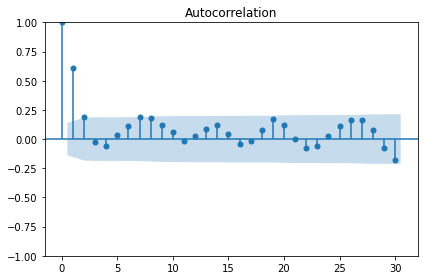

In [107]:
plot_acf(df["values"], lags=30, alpha=alpha)
plt.tight_layout()
plt.show()

In [108]:
train = df[:int(0.9*len(df))]
test = df[int(0.9*len(df)):]
print(len(train))
print(len(test))

180
20


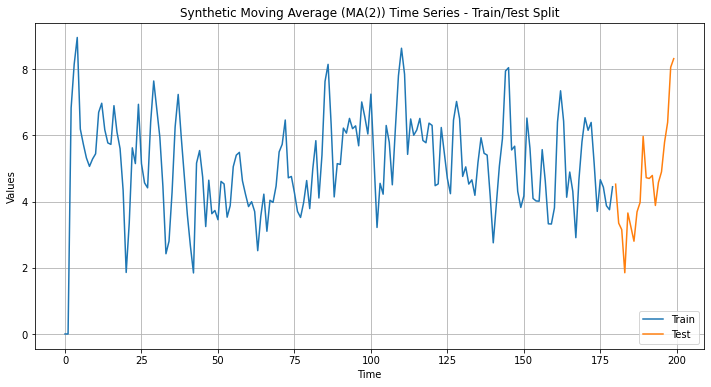

In [109]:

plt.figure(figsize=(12,6))
plt.title('Synthetic Moving Average (MA(2)) Time Series - Train/Test Split')
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.legend()
plt.grid()
plt.show()



In [110]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon
    if method == 'mean':
        pred_mean = []
        #train_len = datos de entrenamiento
        #total_len = datos de entrenamiento + datos de prueba
        #window = salto
        #"Media de la ventana móvil"
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'MA':
        pred_MA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
            
        return pred_MA

In [111]:
pred_df     = test.copy()

TRAIN_LEN   = len(train)
HORIZON     = len(test)
WINDOW      = 2

pred_mean           = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value     = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA             = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'MA')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_MA'] = pred_MA

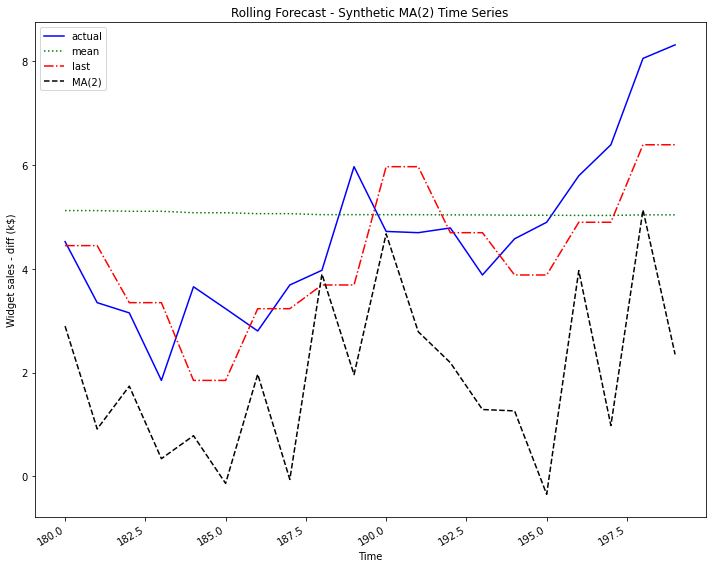

In [112]:

fig, ax = plt.subplots(figsize=(10, 8))

#ax.plot(df['values'])
ax.plot(pred_df['values'], 'b-', label='actual')
ax.plot(pred_df['pred_mean'], 'g:', label='mean')
ax.plot(pred_df['pred_last_value'], 'r-.', label='last')
ax.plot(pred_df['pred_MA'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Widget sales - diff (k$)')

ax.set_title('Rolling Forecast - Synthetic MA(2) Time Series')

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

¿Cual de los 3 métodos produjo el mejor resultado?

Mean: 2.83, Last: 1.46, MA: 9.77


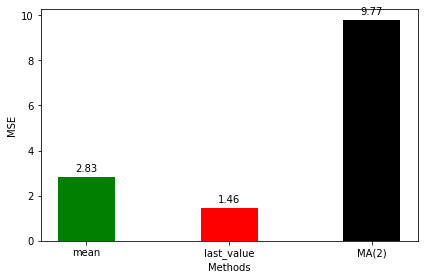

In [113]:

mse_mean    = mean_squared_error(pred_df['values'], pred_df['pred_mean'])
mse_last    = mean_squared_error(pred_df['values'], pred_df['pred_last_value'])
mse_MA      = mean_squared_error(pred_df['values'], pred_df['pred_MA'])
print("Mean: {:.2f}, Last: {:.2f}, MA: {:.2f}".format(mse_mean, mse_last, mse_MA))
fig, ax = plt.subplots()
x = ['mean', 'last_value', 'MA(2)']
y = [mse_mean, mse_last, mse_MA]
ax.bar(x, y, width=0.4, color=['g', 'r', 'k'])
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
#ax.set_ylim(0, 5)
for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')
plt.tight_layout()
plt.show()

Predicción final...

In [114]:
df['pred_widget_sales'] = pd.Series()
df['pred_widget_sales'][450:] = df['widget_sales'].iloc[450] + pred_df['pred_MA'].cumsum()
fig, ax = plt.subplots()
ax.plot(df['widget_sales'], 'b-', label='actual')
ax.plot(df['pred_widget_sales'], 'k--', label='MA(2)')
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (K$)')
ax.axvspan(450, 500, color='#808080', alpha=0.2)
ax.set_xlim(400, 500)
plt.xticks(
    [409, 439, 468, 498], 
    ['Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

KeyError: 'widget_sales'

In [ ]:
from sklearn.metrics import mean_absolute_error
mae_MA_undiff = mean_absolute_error(df['widget_sales'].iloc[450:], df['pred_widget_sales'].iloc[450:])
print(mae_MA_undiff)

2.3244709244319224
